# Read the dataset and create dataloaders

In [1]:
import d2l
import torch
from torch import nn
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm

load the kmnist dataset with torchvision, 
set the train param to True to get the train data, and False for test data
transform the dataset to tensor

In [2]:
import torchvision.datasets as datasets

#load the kmnist dataset with torchvision, 
# set the train param to True to get the train data
# transform the dataset to tensor
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,  transform = transforms.Compose([transforms.ToTensor()]))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
#load the kmnist dataset with torchvision, 
# set the train param to False to get the test data
# transform the dataset to tensor
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))

we set the batch size to 128, then create the dataloaders for train and test

In [4]:
batch_size = 128 
train_iter =  data.DataLoader(mnist_trainset, batch_size, shuffle=True) #train DataLoader object
test_iter =  data.DataLoader(mnist_testset, batch_size, shuffle=True) #test DataLoader object

# **Create the model**

# **Stem Stage**

We break each gray-scale image(1, 28, 28) into 7x7 patches (hence, each of size 4x4). That is, we are going to obtain 7x7=49 sub-images out of a single image.
we obtain the 7 and 4 in the way that the power of these two dimentions should be result to 28. >>>> (4 * 7 = 28) this is for one side of width or height. generally 49 * 16 = 28*28.
The patch size selected for try and error, we can change it during experience. 

In [5]:
class StemStruct(nn.Module):  
    def __init__(self, input_shape, n_patches, batch_size, hidden_d):
        super(StemStruct, self).__init__()

        self.input_shape = input_shape # our image is gray-scale(1 channel) with size of 28*28 pixel so the input_shape is (1, 28, 28)
        self.n_patches = n_patches # number of non-overlapping patches that we want to slice one dimention of the image to, here set to 7
        self.batch_size = batch_size # number of images to process
        self.hidden_d = hidden_d # patch vector transformed to a feature vector of dimension d

        assert self.input_shape[1]%n_patches==0 # image size should be able to divide by n_patches
        assert self.input_shape[2]%n_patches==0

        self.patch_size = int(self.input_shape[1]/n_patches) # we will devide each dimention of image to n_patches and get the patch heaight and width, k * k

        self.linear_mapper = nn.Linear(self.patch_size**2, self.hidden_d) #linear layer transformer, transform patch_size * patch_size to d , (16 to 8)

    def forward(self, x):
      count, channel, _ , _ = x.shape #count is the batch_size which is 128 default, but it is 96 for last batch of iterotor as we have 60,000 samples 
      try:
        #slice the images to Np non-overlapping patches of k*k with reshape method, each patch of k*k=4*4 reshape to a vector of k^2
        patches = x.reshape(count, self.n_patches**2, self.patch_size**2)
      except Exception as e:
        print('>>>>>>>>', x.shape)

      stem_out = self.linear_mapper(patches) # transform patches of k*k to d, output is the matrix of Np*d, generally (batch_size * Np * d)
      return stem_out

test the stem class with fake data

In [6]:
x = torch.rand(3,1,28,28)
model=StemStruct((1,28,28),7,3,8)
model(x).shape

torch.Size([3, 49, 8])

# **Backbone**

MLP consists of 2 fully connected layers and GELU activation function.

In [7]:
class MLP(nn.Module): 
    def __init__(self, input_num, expansion_factor = 4, dropout = 0., dense = nn.Linear):
        """
        dim: input dimention of MLP is Np or patch counts for first MLP and d for second MLP
        expansion_factor: input dimention is expand between MLP linear layers by this factor
        """
        super(MLP, self).__init__()

        self.normalize = nn.LayerNorm(input_num) #normalization layer

        hidden_num = int(input_num * expansion_factor) #input dimention expand between linear layers

        self.mlp = nn.Sequential(
          dense(input_num, hidden_num), #fully connected layer
          nn.GELU(), #activation function
          nn.Dropout(dropout),
          dense(hidden_num, input_num), #fully connected layer
          nn.Dropout(dropout),
      )
        
    def forward(self, x):
      # transpose the input of mlp, we use permute instead of transpose because the input have 3 dimention,
      # first dimention is batch_size which remain fixed and the two others transpose
      x_transpose = x.permute(0,2,1) 
      try:
        x_norm = self.normalize(x_transpose) #normalization layer
        out = self.mlp(x_norm)
      except Exception as e:
        print(e)
        print('>>>>>>>>', x_transpose.shape)
      return out

    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Each block contains 2 MLP, which the first one have the input of number of patches and the second MLP have the input of d

In [8]:
class MLPBlock(nn.Module):
    def __init__(self, all_patches, hidden_dim):
        super().__init__()
        self.mlp1 = MLP(all_patches) #first MLP has input size of Np
        self.mlp1.init_weights()
        self.mlp2 = MLP(hidden_dim) #second MLP has input size of d
        self.mlp2.init_weights()

    def forward(self, x):
        out = self.mlp1(x)
        return self.mlp2(out)

# **Classifier**

Main structure of the network contain stem, 12 MLPBlock, finally average pooling and classifier

In [9]:
class MnistNet(nn.Module):
      def __init__(self, input_shape, n_patches, batch_size, hidden_d, num_blocks, num_classes):
        """
        most of the inputs are related to stem stage
        num_classes: nmber of classess equal to 10
        """
        super().__init__()

        self.num_blocks = num_blocks # number of MLPBlocks used in structure
        self.batch_size = batch_size

        self.normalize = nn.LayerNorm(hidden_d)

        #stem stage
        self.stem = StemStruct(input_shape, n_patches, batch_size, hidden_d)
        
        #Backbone
        self.block = MLPBlock(n_patches*n_patches, hidden_d)

        #classifier
        self.linear_classifier = nn.Linear(hidden_d, num_classes)

      def forward(self, x):
        count, channel, _ , _ = x.shape

        stem_out = self.stem(x)
   
        # apply the MLPBlock, N times
        #store the output in block_out and pass it through next block as input
        block_out = stem_out
        for i in range(self.num_blocks):
          block_out = self.block(block_out)

        #normalyse layer
        norm_block_out = self.normalize(block_out)

        #average pooling
        out = norm_block_out.mean(dim=1).reshape(count,-1)

        #linear classifier
        return self.linear_classifier(out)

# **train the model**

In [10]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in tqdm(range(num_epochs)):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()         
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            #one_hot = torch.nn.functional.one_hot(y).float()
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# **Hyperparameters, Loss, Optimiser**

In [11]:
lr, num_epochs, batch_size = 0.005, 12, 128 #learning rate, number of epochs and batch size
print("learning rate:{}, epochs:{}, batch:{}".format(lr, num_epochs, batch_size))
#create an instance of network
net = MnistNet(input_shape=(1,28,28), n_patches=7, batch_size=128, 
               hidden_d=8, num_blocks=12, num_classes=10)


learning rate:0.005, epochs:12, batch:128


In [12]:
#create loss function
loss = nn.CrossEntropyLoss() 
#create the optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#wd=0.0005
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

# **Results**

100%|██████████| 12/12 [02:45<00:00, 13.79s/it]

loss 0.120, train acc 0.969, test acc 0.964
8770.3 examples/sec on cuda


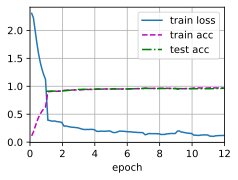

In [13]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu

trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)